# Trigger Level Analysis Plotting for Response and Resolution studies at the ATLAS Experiment

## Abstract
The Trigger Level Analysis (TLA) at the ATLAS experiment uses partly reconstructed particle collision events for its analysis. The smaller data size allows TLA to obtain a much larger number of events and a smaller statisitical uncertainty. This notebook presents the data processing and analysis used to verify the smoothness of the TLA calibration as well as the resolution of the analysis.

## Introduction
When particles collide at the LHC it is possible that new particles are created which decay into decay products. The ATLAS detecor allows us to study the properties of these decay products and learn about the properties of the original particle. Due to the nature of the strong force, the proton-proton collisions at the LHC often one of the most commonly occurring observable objects at ATLAS are the collimated particle showers. From the detector data we can then group the energy deposits of these particle showers into an object called a jet, and by studying these jets we can learn about potential particles created in the collision.

Particle collision event data at the Large Hadron Collider (LHC) at CERN uses a specialized data framework and file format called ROOT. For each particle collision event we can acces, among other things, the jets energy and momentum (and direction in the cylindrical coordinates eta and phi). With this we can represent the two "largest" jets (highest transverse momentum (pT)) as Lorentz vectors and calculate the invariant mass of the particle formed by the collision (if there is any).

Before we run the following code a C++ algorithm has processed millions of simulated particle collision events. With simulated events we can look at the energy and momentum of particles and jets as they would look purley theoretically, called "truth jets". We can also simulate each particles propagation and interaction with the different elements of the detector, as well as the detecotr readout to get a so called "reconstructed jet". Looking at the ratio the transverse momentum, energy, or invariant mass between the reconstructed jets and truth jets can give us important information about our detector and data processing.

The C++ algorithm outputs 3D histograms with response, truth mjj (pT, or energy), truth eta on the x, y, and z axis respectively. This notebook transforms this 3D histogram and transforms it into more understandable plots such as response vs truth mjj using the following steps:

* Fitting
    * 3D histograms are sliced on the z axis and projected into a 2D histogram (each slice is usuallly a truht eta)
    * 2D histograms are sliced in bins on the y axis and projected into 1D histograms (each slice is usuallly a truht pT or truth mjj range/bin width)
    * 1D histograms are fitted with a gaussian using an external python script called "JESBalanceFitter"
    * Information about the gaussian fits are written to disk for future processing
* Plotting
    * A set of the avaliable fit collections is created, one per initial 3D histogram
    * For each 3D histogram the fit mean is plotted at the corresponding 1D histograms pT or mjj bin. Providing a response vs truth mjj plot for all bins

## Loading the 3D histograms


In [1]:
import ROOT
from array import array
from JES_BalanceFitter import JES_BalanceFitter
import numpy as np
import pandas as pd
import pickle

Welcome to JupyROOT 6.20/00


Initialise parameters for fitting

In [2]:
rootFilePath = "/home/pekman/TLA/TH3Files/v14/merged_mc16d_mjj_v14.root"

graphType = "response"

slicingAxis = "z"
choosenSlices = [[-2.8,2.8]]

projectionAxis = "y"
projectionRebinWidth = 1

responseAxis = "x"

nSigmaForFit = 1.3
fitOptString = "RESQ"

Create an empty dataframe with an entry for each 3D histogram

In [3]:
inFile = ROOT.TFile.Open(rootFilePath)
listOfKeys = inFile.GetListOfKeys()

l=[]
for key in listOfKeys:
    TH3Name = key.GetName()
    if TH3Name[0:9] != "scaled_h_":
        continue
    elif inFile.Get(TH3Name).GetEntries()==0.0:
        print("WARNING:",TH3Name," is empty!")
        continue
    else:
        l.append(pd.Series({ "x"            :[],
                             "y"            :[],
                             "xError"         :[],
                             "yError"         :[],
                             "sigma"        :[],
                             "sigmaError"     :[],
                             "sigmaOverY"   :[],
                             "fitAmplitude" :[],
                             "fitMin"       :[],
                             "fitMax"       :[],

                             "TH1BinEdges":[],
                             "TH1BinEntries":[],
                             "TH1BinErrors":[],},
                            name=TH3Name))

df = pd.DataFrame(l)
print(df)

                                                   x   y xError yError sigma  \
scaled_h_-_EM-Online_over_-truth_-_pt_-_eta       []  []     []     []    []   
scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta      []  []     []     []    []   
scaled_h_-_Pileup-Online_over_-truth_-_pt_-_eta   []  []     []     []    []   
scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta  []  []     []     []    []   
scaled_h_-_EtaJES-Online_over_-truth_-_pt_-_eta   []  []     []     []    []   
scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta  []  []     []     []    []   
scaled_h_-_GSC-Online_over_-truth_-_pt_-_eta      []  []     []     []    []   
scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta     []  []     []     []    []   

                                                 sigmaError sigmaOverY  \
scaled_h_-_EM-Online_over_-truth_-_pt_-_eta              []         []   
scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta             []         []   
scaled_h_-_Pileup-Online_over_-truth_-_pt_-_eta          

In [4]:
inFile = ROOT.TFile.Open(rootFilePath)
listOfKeys = inFile.GetListOfKeys()

for TH3Name in df.index:
    print(TH3Name)
    
    #xList, yList, xErrorList, yErrorList, sigmaList, sigmaErrorList, sigmaOverYList, entriesList = array( 'd' ), array( 'd' ), array( 'd' ), array( 'd' ), array( 'd' ), array( 'd' ), array( 'd' ), array( 'd' )
    inTH3 = inFile.Get(TH3Name)
    h3D = inTH3.Clone()
    print(h3D.GetXaxis().GetNbins())

    #set JES_BalanceFitter options
    JESBfitter = JES_BalanceFitter(nSigmaForFit)
    JESBfitter.SetGaus()
    JESBfitter.SetFitOpt(fitOptString)
    
    listOfTH1Content=[]
    listOfGaussians=[]
        
    xnBins = h3D.GetXaxis().GetNbins()
    ynBins = h3D.GetYaxis().GetNbins()

    for bin in choosenSlices:           
        #Get the bin which corresponds to the desired slice axis range
        if slicingAxis == "y":
            h3D.GetYaxis().SetRangeUser(bin[0], bin[1])     
        elif slicingAxis == "z":
            h3D.GetZaxis().SetRangeUser(bin[0], bin[1]) 
                          
        #Project the 3D histogram with the set y-axis range
        h2D=h3D.Project3D(responseAxis + projectionAxis)
         
        #rebin according to the desired rebinningFactor
        h2D.RebinX(projectionRebinWidth)
                
        currentRebinnedBin = 1; 
        for currentRebinnedBin in range(1, h2D.GetNbinsX()+1):
            #name of projection
            projName = "slice"+str(bin[0])+"to"+str(bin[1])+"_projectionBin"+str(h2D.GetXaxis().GetBinLowEdge(currentRebinnedBin))+"to"+str(h2D.GetXaxis().GetBinUpEdge(currentRebinnedBin))
 
            #take projection
            h1D=h2D.ProjectionY(projName, currentRebinnedBin, currentRebinnedBin)
            
            #skip empty bins
            if h1D.GetEntries() == 0:
                #print("empty 1D hist, skipping!")
                continue
            
            #fitting limits
            fitMax = h1D.GetMean() + nSigmaForFit * h1D.GetRMS()
            fitMin = h1D.GetMean() - nSigmaForFit * h1D.GetRMS()
            
            #obtain fit using JES_BalanceFitter and associate it to the TH1           
            JESBfitter.Fit(h1D, fitMin, fitMax)
            fit = JESBfitter.GetFit()
            histFit = JESBfitter.GetHisto()
            Chi2Ndof = JESBfitter.GetChi2Ndof()
            histFit.GetListOfFunctions().Add(fit)

            binEdges=[]
            binEntries=[]
            binErrors=[]
            for i in range(1, h1D.GetNbinsX()+1):#Plus one to include last bin, this is simple python syntax
              binEdges.append(h1D.GetXaxis().GetBinLowEdge(i))
              binEntries.append(h1D.GetBinContent(i))
              binErrors.append(h1D.GetBinError(i))
            binErrors.append(h1D.GetXaxis().GetBinUpEdge(h1D.GetNbinsX()))# Append the right most edge
            
            
            df["x"].loc[TH3Name].append(float(h2D.GetXaxis().GetBinCenter(currentRebinnedBin)))
            df["y"].loc[TH3Name].append(float(fit.GetParameter(1)))
            df["xError"].loc[TH3Name].append(float((h2D.GetXaxis().GetBinWidth(currentRebinnedBin)/2.0)))#half bin width
            df["yError"].loc[TH3Name].append(float(fit.GetParError(1)))
            df["sigma"].loc[TH3Name].append(float(fit.GetParameter(2)))
            df["sigmaError"].loc[TH3Name].append(float(fit.GetParError(2)))
            try: 
                df["sigmaOverY"].loc[TH3Name].append(float(fit.GetParameter(2) / float(fit.GetParameter(1))))
            except: 
                df["sigmaOverY"].loc[TH3Name].append(0)
                
            df["TH1BinEdges"].loc[TH3Name].append(binEdges)
            df["TH1BinEntries"].loc[TH3Name].append(binEntries)
            df["TH1BinErrors"].loc[TH3Name].append(binErrors)
        
inFile.Close()

df.to_pickle("TH3Dataframe.pickle")

scaled_h_-_EM-Online_over_-truth_-_pt_-_eta
300
scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta
300
scaled_h_-_Pileup-Online_over_-truth_-_pt_-_eta
300
scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta
300
scaled_h_-_EtaJES-Online_over_-truth_-_pt_-_eta
300
scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta
300
scaled_h_-_GSC-Online_over_-truth_-_pt_-_eta
300
scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta
300


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


## Plotting

In [5]:
import scipy as scipy
import matplotlib.pyplot as plt
import mplhep as hep

TH3 Name: scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


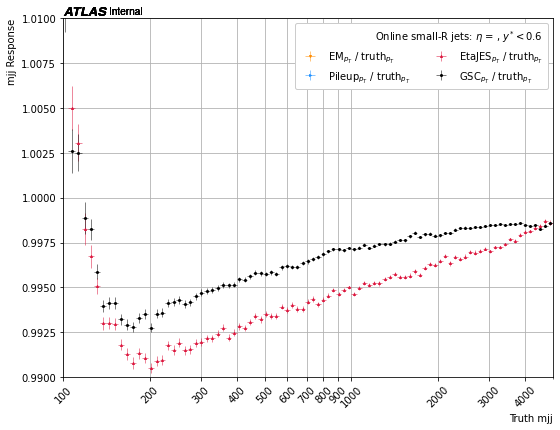

In [7]:
df = pd.read_pickle("./TH3Dataframe.pickle")

DataOrMC = "MC"
#DataOrMC = "Data"
OnlineOrOffline = "Online"
f, ax = plt.subplots(figsize=(8, 6),sharex=True)

iColors = 0
iMarkers = 0

denominatorType = "Truth"
projectionAxisUnit = "mjj"
#print(listOfTH3Names)

markers = ["v",">","^","o"]
colors = ["darkorange","dodgerblue","crimson","black"]

i=-1

for TH3Name in df.index:
    if "_pt_" in TH3Name:
        continue
    i+=1
    print("TH3 Name:",TH3Name)

    x=df["x"].loc[TH3Name]
    y=df["y"].loc[TH3Name]
    x_error=df["xError"].loc[TH3Name]
    y_error=df["yError"].loc[TH3Name]
    
    numerator = TH3Name.split("_-_")[1].split("_")[0].split("-")[0]
    denominator = TH3Name.split("_-_")[1].split("_")[2].split("-")[0]
    if denominator == "":
        denominator = TH3Name.split("_-_")[1].split("_")[2].split("-")[1]
    my_label=numerator+"$_{p_T}$"+" / "+denominator+"$ _{p_T}$"
    
    ax.errorbar(x, y, yerr=y_error, xerr=x_error,
                linestyle='None',
                marker=markers[i],
                color=colors[i],
                markersize=2,
                linewidth=0.5,
                label=my_label)

    # Legend
    leg = ax.legend(borderpad=0.5, loc=1, ncol=2, frameon=True,facecolor="white",framealpha=1)
    fileName=rootFilePath.split("/")[-1]
    dataType = fileName.split("_")[1]
    numerator = TH3Name.split("_-_")[1].split("_")[0].split("-")[0]
    leg._legend_box.align = "right"
    leg.set_title("Online small-R jets: "+"$\eta$ = "+", $y^{*}<0.6$")#+"\nFit range:["+str(round(x[0],0))+", "+str(round(x[-1],0))+"] GeV")

    # Apply ATLAS labels and ticks
    plt.sca(ax)
    plt.xticks(rotation=45)
    ax.grid()

    plt.sca(ax)
    plt.xticks(rotation=45)
    ax.set_axisbelow(True)
    ax.set_xticks([300,400,500,600,700,800,900,1000,2000,3000])

    iColors+=1
    iMarkers+=1

    ax = plt.gca()
    ax.grid(True)
    ax.set_axisbelow(True)

    hep.atlas.text("Internal",ax=ax)
    #for entry in inFile['x']:
    #    print(entry)
    #break
        
    #plt.tight_layout()
    f.subplots_adjust(left=0.1, right=0.95, bottom=0.12, top=0.95)

    # Set limits and labels
    ax.set_xlim(100,5000)
    ax.set_ylim(0.99,1.01)
    ax.set_ylabel("mjj Response", ha='right', y=1.0)
    ax.set_xlabel("Truth mjj", ha='right',x=1.0)
    ax.set_xscale("log")

    tickList = [1,2,3,4,5,6,7,8,9,
    10,20,30,40,50,60,70,80,90,
    100,200,300,400,500,600,700,800,900,
    1000,2000,3000,4000,5000,6000,7000,8000,9000,
    10000]
    tickLabelList = [1,2,3,4,5,6,7,8,9,
    10,20,30,40,50,60,70,80,90,
    100,200,300,400,500,600,700,800,900,
    1000,2000,3000,4000,5000,6000,7000,8000,9000,
    10000]

    ax.set_xticks(tickList[tickList.index(100):tickList.index(5000)])
    ax.set_xticklabels(tickLabelList[tickLabelList.index(100):tickLabelList.index(5000)])

    f.savefig(denominatorType+"_-_"+projectionAxisUnit+".pdf")